<a href="https://colab.research.google.com/github/saai07/LLM_finetuning/blob/main/SmolVLM2-500M-Video-finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install trl

Import Dependencies

In [2]:
import transformers
import trl

import torch

# Note: I'm running this locally on a NVIDIA DGX Spark, if you are running on Google Colab, make sure you've activate a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


 Load dataset

In [3]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("mrdbourke/FoodExtract-1k-Vision")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image_id', 'image_name', 'food101_class_name', 'food101_split', 'image_source', 'qwen3_vl_8b_yaml_out', 'qwen3_vl_inference_time', 'output_label_json', 'is_food', 'image'],
        num_rows: 1510
    })
})

In [4]:
example_sample = dataset["train"][0]

example_sample

{'image_id': '3233632',
 'image_name': '3233632.jpg',
 'food101_class_name': 'cheese_plate',
 'food101_split': 'train',
 'image_source': 'food101',
 'qwen3_vl_8b_yaml_out': 'point_of_view: 45-degree\ndishes:\n  - cheese plate\nfood_items:\n  - cheese wedge\n  - toast\n  - herb garnish\n  - dipping sauce\ndrink_items: []\ncontainers_and_utensils:\n  - white plate\n  - small white bowl\nattributes:\n  - sliced\n  - garnished\n  - served with accompaniments',
 'qwen3_vl_inference_time': 1.6110260486602783,
 'output_label_json': {'is_food': 1,
  'image_title': 'cheese plate',
  'food_items': ['toast', 'herb garnish', 'dipping sauce', 'cheese wedge'],
  'drink_items': []},
 'is_food': 1,
 'image': <PIL.Image.Image image mode=RGB size=512x512>}

[INFO] Example desired output:
{'is_food': 1, 'image_title': 'cheese plate', 'food_items': ['toast', 'herb garnish', 'dipping sauce', 'cheese wedge'], 'drink_items': []}
[INFO] Example image input:


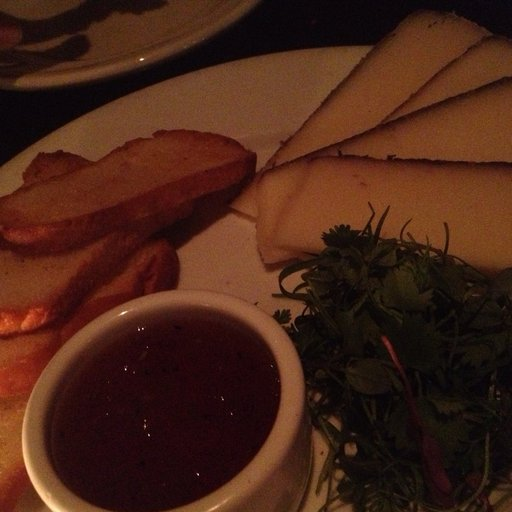

In [5]:
example_input = example_sample["image"]
example_output = example_sample["output_label_json"]

print(f"[INFO] Example desired output:\n{example_output}")

print(f"[INFO] Example image input:")
example_input

In [7]:
# System message
SYSYTEM_MESSAGE = """You are an expert food and drink image extractor.
You provide structured data to visual inputs classifying them as edible food/drink or not.
As well as titling the image with a simple food/drink related caption.
Finally you extract any and all visible food/drink items to lists.
"""

# User prompt with image input as well as desired output
USER_PROMPT = """Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.

Only return valid JSON in the following form:

```json
{
  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)
  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present
  'food_items': [], # list[str] - list of visible edible food item nouns
  'drink_items': [] # list[str] - list of visible edible drink item nouns
}
```
"""

# Create helper function to map our input/output samples to conversational format
def format_data(sample):
    return {
        "messages": [

            # Message 0 - [SYSTEM] System Prompt (setting the scene)
            {
                "role": "system",
                "content": [{"type": "text", "text": SYSYTEM_MESSAGE}]
            },

            # Message 1 - [USER] User input (image + prompt pair)
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": sample["image"],
                    },
                    {
                        "type": "text",
                        "text": USER_PROMPT # Note: In a future extension, you might train the model to not require any text input and just go straight from image -> text output
                    }
                ],
            },

            # Message 2 - [MODEL] Ideal model output (e.g. our structured data format)
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample["output_label_json"]}]
            }
        ]
    }

formatted_sample = format_data(sample=example_sample)
formatted_sample

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=512x512>},
    {'type': 'text',
     'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods pr

In [8]:
dataset_processed = [format_data(sample) for sample in dataset["train"]]
dataset_processed[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=512x512>},
    {'type': 'text',
     'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods pr

In [9]:
import random
from pprint import pprint

random.seed(42)
dataset_shuffled = random.sample(dataset_processed, k=len(dataset_processed))

# Use 80% split for training, 20% for validation
train_split = round(0.8 * len(dataset_shuffled))

train_dataset = dataset_shuffled[:train_split]
val_dataset = dataset_shuffled[train_split:]
print(f"[INFO] Number of total samples: {len(dataset_processed)}")
print(f"[INFO] Number of train samples: {len(train_dataset)}")
print(f"[INFO] Number of eval samples: {len(val_dataset)}")

print(f"\n[INFO] Example training sample:\n")
pprint(train_dataset[0])
print(f"\n[INFO] Example validation sample:\n")
pprint(val_dataset[0])

[INFO] Number of total samples: 1510
[INFO] Number of train samples: 1208
[INFO] Number of eval samples: 302

[INFO] Example training sample:

{'messages': [{'content': [{'text': 'You are an expert food and drink image '
                                    'extractor.\n'
                                    'You provide structured data to visual '
                                    'inputs classifying them as edible '
                                    'food/drink or not.\n'
                                    'As well as titling the image with a '
                                    'simple food/drink related caption.\n'
                                    'Finally you extract any and all visible '
                                    'food/drink items to lists.\n',
                            'type': 'text'}],
               'role': 'system'},
              {'content': [{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x678 at 0x7FB3A2591D00>,
                     

In [10]:
example_base_model_input = dataset_processed[0]["messages"][:2] # the "assistant" text output is what we want our model to predict
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items

loading model

In [11]:
from huggingface_hub import notebook_login

notebook_login()

In [12]:
!pip install num2words

In [13]:


from transformers import pipeline

# Other models to try
# MODEL_ID = "google/gemma-3n-e2b-it" # note: this model is 5B parameters and performs quite well, however, it's not quite as "small" as we'd like
# MODEL_ID = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"

MODEL_ID = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"

pipe = pipeline(
    "image-text-to-text",
    model=MODEL_ID,
    device="cuda",
    dtype=torch.bfloat16
)

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

In [14]:
# Test the base model on an example input image
base_model_output = pipe(text=example_base_model_input,
                         max_new_tokens=256)

print(f'[INFO] Base model input (text only):\n{example_base_model_input}\n')
print(f'[INFO] Base model output:\n{base_model_output[0]["generated_text"][-1]["content"]}\n')
print(f'[INFO] Desired output:\n{dataset_processed[0]["messages"][-1]["content"][0]["text"]}')

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Base model input (text only):
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7FB3A83385F0>}, {'type': 'text', 'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank

In [15]:
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items

In [16]:
# Test the base model on an example input image
base_model_output = pipe(text=example_base_model_input,
                         max_new_tokens=256)

print(f'[INFO] Base model input (text only):\n{example_base_model_input}\n')
print(f'[INFO] Base model output:\n{base_model_output[0]["generated_text"][-1]["content"]}\n')
print(f'[INFO] Desired output:\n{dataset_processed[0]["messages"][-1]["content"][0]["text"]}')

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Base model input (text only):
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7FB3A83385F0>}, {'type': 'text', 'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank

 Create a training and validation split

In [17]:
import random
from pprint import pprint

random.seed(42)
dataset_shuffled = random.sample(dataset_processed, k=len(dataset_processed))

# Use 80% split for training, 20% for validation
train_split = round(0.8 * len(dataset_shuffled))

train_dataset = dataset_shuffled[:train_split]
val_dataset = dataset_shuffled[train_split:]
print(f"[INFO] Number of total samples: {len(dataset_processed)}")
print(f"[INFO] Number of train samples: {len(train_dataset)}")
print(f"[INFO] Number of eval samples: {len(val_dataset)}")

print(f"\n[INFO] Example training sample:\n")
pprint(train_dataset[0])
print(f"\n[INFO] Example validation sample:\n")
pprint(val_dataset[0])

[INFO] Number of total samples: 1510
[INFO] Number of train samples: 1208
[INFO] Number of eval samples: 302

[INFO] Example training sample:

{'messages': [{'content': [{'text': 'You are an expert food and drink image '
                                    'extractor.\n'
                                    'You provide structured data to visual '
                                    'inputs classifying them as edible '
                                    'food/drink or not.\n'
                                    'As well as titling the image with a '
                                    'simple food/drink related caption.\n'
                                    'Finally you extract any and all visible '
                                    'food/drink items to lists.\n',
                            'type': 'text'}],
               'role': 'system'},
              {'content': [{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x678 at 0x7FB3A2591D00>,
                     

In [18]:
example_base_model_input = dataset_processed[0]["messages"][:2] # the "assistant" text output is what we want our model to predict
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items

Loading a base model

In [19]:
from transformers import pipeline

# Other models to try
# MODEL_ID = "google/gemma-3n-e2b-it" # note: this model is 5B parameters and performs quite well, however, it's not quite as "small" as we'd like
# MODEL_ID = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"

MODEL_ID = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"

pipe = pipeline(
    "image-text-to-text",
    model=MODEL_ID,
    device="cuda",
    dtype=torch.bfloat16
)

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

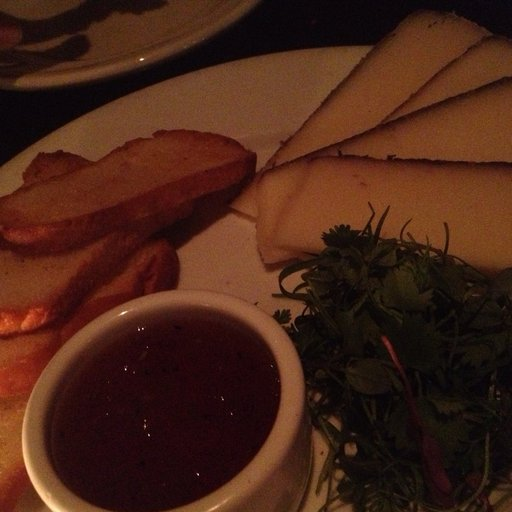

In [23]:
example_base_model_input[1]["content"][0]["image"]

Load the model without using pipeline

In [24]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

print(f"[INFO] Using model: {MODEL_ID}")

# Define model init args
model_kwargs = dict(
    attn_implementation="eager", # Note: could also use flash_attention_2 here for faster models, requires `pip install flash-attn` (see: https://github.com/Dao-AILab/flash-attention)
    dtype=torch.bfloat16,
    device_map="auto"
)

# Load the model and tokenizer/processor
model = AutoModelForImageTextToText.from_pretrained(MODEL_ID,
                                                    **model_kwargs)
processor = AutoProcessor.from_pretrained(MODEL_ID)

[INFO] Using model: HuggingFaceTB/SmolVLM2-500M-Video-Instruct


Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

In [25]:
model

SmolVLMForConditionalGeneration(
  (model): SmolVLMModel(
    (vision_model): SmolVLMVisionTransformer(
      (embeddings): SmolVLMVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): SmolVLMEncoder(
        (layers): ModuleList(
          (0-11): 12 x SmolVLMEncoderLayer(
            (self_attn): SmolVLMVisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): SmolVLMVisionMLP(
              (activation_fn): GELUTanh()
              (fc1): Linear(in_features=768, out_feature

In [26]:
# Apply the chat template
example_chat_template_input = processor.apply_chat_template(
    [example_base_model_input[1]], # Note: if we are running this way, format the system_prompt to either be removed or folded into the user_prompt
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(device)
print(f"[INFO] Chat template:\n{example_chat_template_input}\n")

# Measure how long our input prompt is (our model will generate tokens *after* the input prompt)
input_len = example_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

# Perform inference with the base model
with torch.no_grad():
    generation_output_full = model.generate(**example_chat_template_input,
                                            max_new_tokens=256,
                                            do_sample=False)
    generation_output_short = generation_output_full[0][input_len:]

# Decode the outputs from tokens -> readable text
decoded_outputs = processor.decode(generation_output_short,
                                   skip_special_tokens=True)

# Print inputs and outputs
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the raw token (numerical) intput to our model:\n")
print(example_chat_template_input["input_ids"][0])
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the raw pixel values (numerical) intput to our model:\n")
print(example_chat_template_input["pixel_values"][0])
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the input to our model in human-readable form (note: our model will not see in the input like this):\n")
print(processor.decode(example_chat_template_input["input_ids"][0]))
print("\n"+"-"*50+"\n")
print(f"[INFO] Outputs from the base model:\n")
print(decoded_outputs)

[INFO] Chat template:
{'pixel_values': tensor([[[[[-0.3804, -0.3804, -0.3804,  ..., -0.8431, -0.8431, -0.8353],
           [-0.3804, -0.3804, -0.3804,  ..., -0.8353, -0.8353, -0.8275],
           [-0.3804, -0.3804, -0.3804,  ..., -0.8353, -0.8353, -0.8275],
           ...,
           [-0.9216, -0.9216, -0.9216,  ..., -0.0667, -0.0667, -0.0745],
           [-0.9216, -0.9216, -0.9216,  ..., -0.0667, -0.0667, -0.0745],
           [-0.9137, -0.9137, -0.9137,  ..., -0.0745, -0.0745, -0.0745]],

          [[-0.6549, -0.6549, -0.6549,  ..., -0.9216, -0.9216, -0.9059],
           [-0.6549, -0.6549, -0.6549,  ..., -0.9137, -0.9137, -0.8980],
           [-0.6549, -0.6549, -0.6549,  ..., -0.9137, -0.9137, -0.8980],
           ...,
           [-0.9608, -0.9608, -0.9608,  ..., -0.4275, -0.4275, -0.4353],
           [-0.9608, -0.9608, -0.9608,  ..., -0.4275, -0.4275, -0.4353],
           [-0.9608, -0.9608, -0.9608,  ..., -0.4353, -0.4353, -0.4353]],

          [[-0.8039, -0.8039, -0.8039,  ..., -0.9

Prepare model for training

In [27]:
# Freeze the vision backbone and only train the LLM parts
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen

# Before freezing parameters
total_params, trainable_params, frozen_params = count_parameters(model)
print(f"[INFO] Params Total (before freezing the vision model): {total_params:,} | Params Trainable: {trainable_params:,} | Params Frozen: {frozen_params:,}")

# Freeze the vision encoder
for param in model.model.vision_model.parameters():
    # Turn off graidents in the vision model
    param.requires_grad = False

# After freezing parameters
total_params, trainable_params, frozen_params = count_parameters(model)
print(f"[INFO] Params Total (after freezing the vision model): {total_params:,} | Params Trainable: {trainable_params:,} | Params Frozen: {frozen_params:,}")

[INFO] Params Total (before freezing the vision model): 507,482,304 | Params Trainable: 507,482,304 | Params Frozen: 0
[INFO] Params Total (after freezing the vision model): 507,482,304 | Params Trainable: 421,049,280 | Params Frozen: 86,433,024




Creating a data collator



In [29]:
def convert_message_to_list_of_images(messages: list[dict]) -> list[Image.Image]:
    """Helper function to turn our message samples into lists of images.

    Note: this comes from here: https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora"""
    image_inputs = []

    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))

    return image_inputs

def collate_fn(examples):
    """Helper function to stack together image + text pairs into batches."""

    # Create empty lists for batches of text and images
    texts = []
    images = []

    # Loop through examples and preprocess them
    for example in examples:
        image_inputs = convert_message_to_list_of_images(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch_input = processor(text=texts,
                            images=images,
                            return_tensors="pt",
                            padding=True)

    # The labels are the input_ids and we mask the padding tokens and image tokens in the loss computation
    labels = batch_input["input_ids"].clone()

    # Get the image token
    image_token_id = processor.tokenizer.convert_tokens_to_ids("<image>")

    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100 # pad_token_id = 2
    labels[labels == image_token_id] = -100 # image_token_id = 49190, this is the `<image>` token which is a placeholder, we don't need our model to learn to predict those

    batch_input["labels"] = labels

    return batch_input

# For SmolVLM2, check the image token
image_token_id = processor.tokenizer.convert_tokens_to_ids("<image>")
print(f"[INFO] SmolVLM2 uses the following for the image_token_id: {image_token_id}, we mask this token as it is only a placeholder in our sequence of tokens (we don't need the model to learn to predict it).")

[INFO] SmolVLM2 uses the following for the image_token_id: 49190, we mask this token as it is only a placeholder in our sequence of tokens (we don't need the model to learn to predict it).


setting up STFconfig

In [39]:
from trl import SFTConfig

# Note: Many of these hyperparameters have been taken from the SmolDocling paper: https://arxiv.org/abs/2503.11576
training_args = SFTConfig(
    output_dir="smolvlm2-500m-FoodTagExtract-Vision-v1-VIDEO",
    num_train_epochs=1, # depending on how much data you have you may want to train for shorter/longer
    per_device_train_batch_size=1, # GPU POOR
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=1,
    max_grad_norm=1.0,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to="none",
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    load_best_model_at_end=True,
    remove_unused_columns = False
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Train the model with SFTTraine

In [40]:
len(train_dataset), len(val_dataset)

(1208, 302)

In [41]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    # train_dataset=train_dataset[:1000],
    # eval_dataset=val_dataset[:100],
    train_dataset=train_dataset[:50], # Lowered for the video (faster)
    eval_dataset=val_dataset[:10], # Lowered for the video (faster)
    # peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,

)

trainer.train()

Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.56 GiB of which 457.81 MiB is free. Including non-PyTorch memory, this process has 14.11 GiB memory in use. Of the allocated memory 9.10 GiB is allocated by PyTorch, and 4.88 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [42]:
trainer.save_model()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

plotting

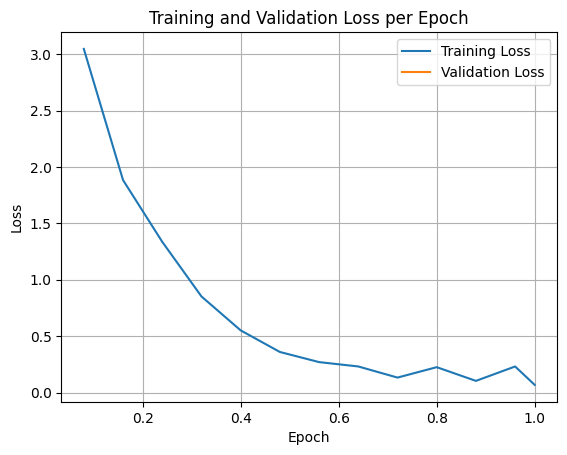

In [43]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Upload the fine-tuned model to the Hugging Face Hub

In [44]:
# Upload to Hugging Face
from huggingface_hub import HfApi, create_repo

api = HfApi()

# Give our model a name (this is in the format [Hugging Face Username]/[Target Model Name]
repo_id = "sai237/FoodTagExtract-Vision-SmolVLM2-500M-fine-tune-v1-VIDEO"

# Create the repo
create_repo(repo_id,
            repo_type="model",
            exist_ok=True)

# Upload the entire model folder containing our model files
api.upload_folder(
    folder_path="./smolvlm2-500m-FoodTagExtract-Vision-v1-VIDEO/",
    repo_id=repo_id,
    repo_type="model"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...1-VIDEO/model.safetensors:   0%|          | 51.3kB / 1.02GB            

  ...1-VIDEO/training_args.bin:  10%|#         |   572B / 5.71kB            

CommitInfo(commit_url='https://huggingface.co/sai237/FoodTagExtract-Vision-SmolVLM2-500M-fine-tune-v1-VIDEO/commit/450fcfd04400d9a9f4f21c4b4162573c7a020bfb', commit_message='Upload folder using huggingface_hub', commit_description='', oid='450fcfd04400d9a9f4f21c4b4162573c7a020bfb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sai237/FoodTagExtract-Vision-SmolVLM2-500M-fine-tune-v1-VIDEO', endpoint='https://huggingface.co', repo_type='model', repo_id='sai237/FoodTagExtract-Vision-SmolVLM2-500M-fine-tune-v1-VIDEO'), pr_revision=None, pr_num=None)

creating gradio demo

In [46]:
# Make a directory to store our demos
!mkdir demos

In [47]:
# Make a directory to store our demos
!mkdir demos/FoodExtract-Vision-v1

In [50]:
%%writefile demos/FoodExtract-Vision-v1/app.py
import torch
import gradio as gr

import spaces
from transformers import pipeline

BASE_MODEL_ID = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"
FINE_TUNED_MODEL_ID = "sai237/FoodTagExtract-Vision-SmolVLM2-500M-fine-tune-v1"
OUTPUT_TOKENS = 256

# Load original base model (no fine-tuning)
print(f"[INFO] Loading Original Model")
original_pipeline = pipeline(
    "image-text-to-text",
    model=BASE_MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto"
)

# Load fine-tuned model
print(f"[INFO] Loading Fine-tuned Model")
ft_pipe = pipeline(
    "image-text-to-text",
    model=FINE_TUNED_MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto"
)

def create_message(input_image):
    return [{'role': 'user',
 'content': [{'type': 'image',
   'image': input_image},
  {'type': 'text',
   'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items': [], # list[str] - list of visible edible food item nouns\n  'drink_items': [] # list[str] - list of visible edible drink item nouns\n}\n```\n"}]}]

@spaces.GPU
def extract_foods_from_image(input_image):
    input_image = input_image.resize(size=(512, 512))
    input_message = create_message(input_image=input_image)

    # Get outputs from base model (not fine-tuned)
    original_pipeline_output = original_pipeline(text=[input_message],
                                                 max_new_tokens=OUTPUT_TOKENS)

    outputs_pretrained = original_pipeline_output[0][0]["generated_text"][-1]["content"]

    # Get outputs from fine-tuned model (fine-tuned on food images)
    ft_pipe_output = ft_pipe(text=[input_message],
                             max_new_tokens=OUTPUT_TOKENS)
    outputs_fine_tuned = ft_pipe_output[0][0]["generated_text"][-1]["content"]

    return outputs_pretrained, outputs_fine_tuned

demo_title = "🥑➡️📝 FoodExtract-Vision with a fine-tuned SmolVLM2-500M"
demo_description = """* **Base model:** https://huggingface.co/HuggingFaceTB/SmolVLM-500M-Instruct
* **Fine-tuning dataset:** https://huggingface.co/datasets/mrdbourke/FoodExtract-1k-Vision (1k food images and 500 not food images)
* **Fine-tuned model:** https://huggingface.co/sai237/FoodTagExtract-Vision-SmolVLM2-500M-fine-tune-v1-VIDEO
## Overview

Extract food and drink items in a structured way from images.

The original model outputs fail to capture the desired structure. But the fine-tuned model sticks to the output structure quite well.

However, the fine-tuned model could definitely be improved with respects to its ability to extract the right food/drink items.

Both models use the input prompt:

````
Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.

Only return valid JSON in the following form:

```json
{
  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)
  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present
  'food_items': [], # list[str] - list of visible edible food item nouns
  'drink_items': [] # list[str] - list of visible edible drink item nouns
}
```
````

Except one model has been fine-tuned on the structured data whereas the other hasn't.

Notable next steps would be:
* **Remove the input prompt:** Just train the model to go straight from image -> text (no text prompt on input), this would save on inference tokens.
* **Fine-tune on more real-world data:** Right now the model is only trained on 1k food images (from Food101) and 500 not food (random internet images), training on real world data would likely significantly improve performance.
* **Fix the repetitive generation:** The model can sometimes get stuck in a repetitive generation pattern, e.g. "onions", "onions", "onions", etc. We could look into patterns to help reduce this.
"""

demo = gr.Interface(
    fn=extract_foods_from_image,
    inputs=gr.Image(type="pil"),
    title=demo_title,
    description=demo_description,
    outputs=[gr.Textbox(lines=4, label="Original Model (not fine-tuned)"),
             gr.Textbox(lines=4, label="Fine-tuned Model")],
    examples=[["examples/camera.jpeg"],
              ["examples/Tandoori-Chicken.jpg"],
              ["examples/fries.jpeg"]],
)

if __name__ == "__main__":
    demo.launch(share=False)

Overwriting demos/FoodExtract-Vision-v1/app.py
